/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


AttributeError: 'DDPMDynamic' object has no attribute 'temp'

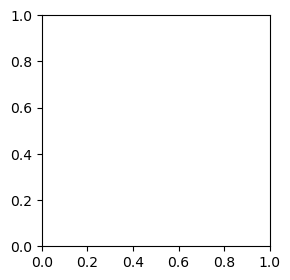

In [1]:
from config import load_config
from diffusion import get_ddpm
import matplotlib.pyplot as plt


cfg = load_config()

cfg.ddpm.schedule_type = "linear_beta"
dyn_linear = get_ddpm(cfg).dynamic
cfg.ddpm.schedule_type = "flattening_temp"
dyn_flat = get_ddpm(cfg).dynamic
cfg.ddpm.schedule_type = "flattening_temp_unbiased"
dyn_flat_unbiased = get_ddpm(cfg).dynamic


dyns = {
    "linear": dyn_linear,
    "flat": dyn_flat,
    "flat_unbiased": dyn_flat_unbiased,
}


plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)

for name, dyn in dyns.items():
    plt.plot(dyn.temp, label=name)

plt.yscale("log")
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.legend()


plt.subplot(1, 3, 2)

for name, dyn in dyns.items():
    plt.plot(dyn.alpha_bar, label=name)

plt.xlabel("timestamp")
plt.ylabel("alpha_bar")
plt.legend()
plt.yscale("log")


plt.subplot(1, 3, 3)

for name, dyn in dyns.items():
    plt.plot(dyn.beta, label=name)

plt.xlabel("timestamp")
plt.ylabel("beta")
plt.legend()
plt.yscale("log")

plt.tight_layout()
plt.show()

C:\Users\anton\AppData\Local\Temp\ipykernel_25952\2352353678.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot((dyn_linear.temp - T) / T, label="discrete")


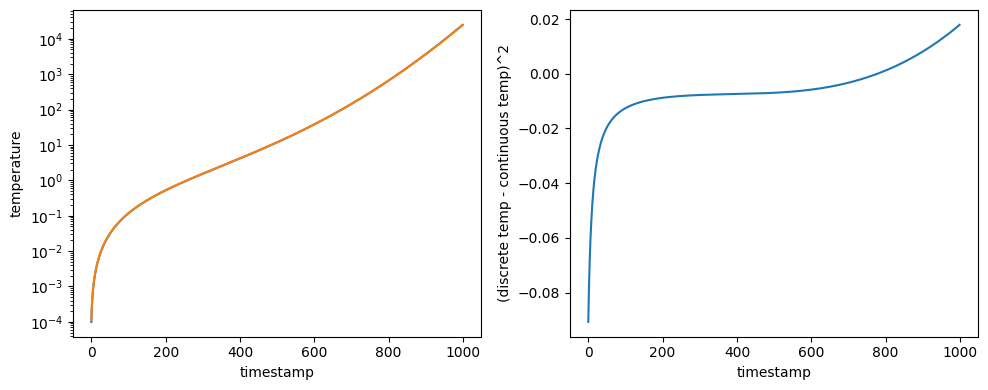

In [27]:
import numpy as np


alpha = np.linspace(1e-3, 1, 1000)
T = np.exp(0.1 * alpha + 10 * alpha ** 2) - 1


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(dyn_linear.temp, label="discrete")
plt.plot(T, label="continuous")
plt.yscale("log")
plt.xlabel("timestamp")
plt.ylabel("temperature")


plt.subplot(1, 2, 2)
plt.plot((dyn_linear.temp - T) / T, label="discrete")
plt.xlabel("timestamp")
plt.ylabel("(discrete temp - continuous temp)^2")
# plt.yscale("log")


plt.tight_layout()
plt.show()

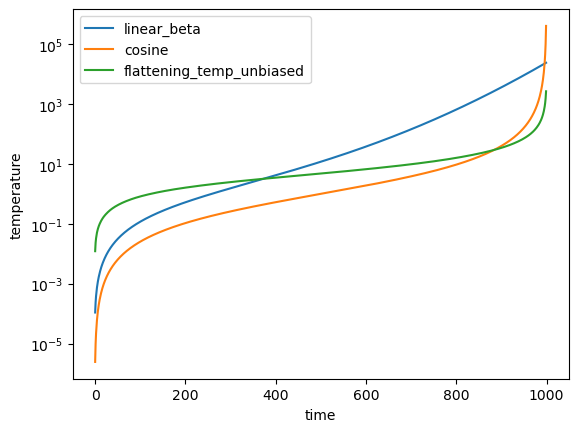

In [6]:
from config import load_config
from diffusion import get_ddpm
import matplotlib.pyplot as plt
from utils import get_time_evenly_spaced


config = load_config()
for schedule_type in ["linear_beta", "cosine", "flattening_temp_unbiased"]:
    config.ddpm.schedule_type = schedule_type
    t = get_time_evenly_spaced(1000)
    temp = get_ddpm(config).dynamic.get_temp(t).view(-1)
    plt.plot(temp, label=schedule_type)

plt.xlabel("time")
plt.ylabel("temperature")
plt.yscale("log")
plt.legend()
plt.show()